<a href="https://colab.research.google.com/github/huntersarnelli/Used-Cars/blob/main/Car_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install catboost

In [6]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.cluster import DBSCAN
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e9:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F76728%2F9057646%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240906%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240906T000921Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D179af79833e774e0e62fc152d5bdf51260d54626e8956a5a6ec062b8c660fc773d7a304d0540d813a729b4d6c5bbb6a90d89373af0b28b32debd825adfbd4e6bd961f1b56440826543e2a9dbc56347d42e853cd49e21c368f1fcafa26ae7f5b7ae0096a7424e3af84cb17685504e51459d91681a7cb3865de869181980927b7f7a60c9f312959a5598e759174a454a7d51156435d4eb86e3e0005a9003badfe6dd8f6b9806cd1f5ac51f7455f00c21dc4e04a990a9125a28b56f895f5eb16b23b1ee21249023d728d7b2d0b2b295220db2ec1caf7b9bb4dd2408994872d8d5a79c6f6123c00e5a966595dc7e8da0c475d58f4fdbd662f8c43a6fd5e83051bc0b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 8223535 bytes downloaded
Downloaded and uncompressed: playground-series-s4e9
Data source import complete.


In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/test.csv


In [8]:
df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df.head(1)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [10]:
df['clean_title'] = df['clean_title'].fillna('no')

<Axes: >

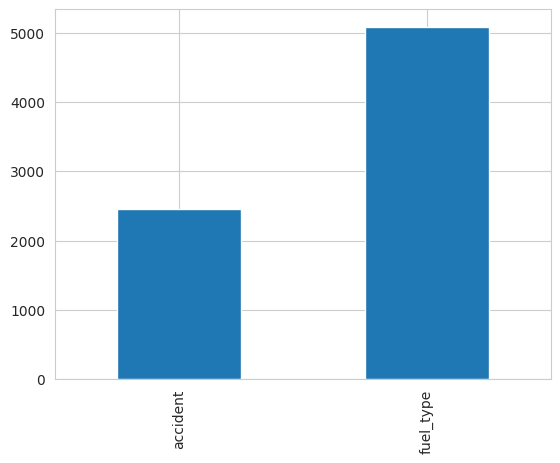

In [11]:
sns.set_style("whitegrid")
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [12]:
# Function to impute missing values based on the mode of a group
def impute_fuel_type(row, impute_dict):
    if pd.isna(row['fuel_type']):
        return impute_dict.get((row['model'], row['engine']), row['fuel_type'])
    return row['fuel_type']

# Creating a dictionary with (model_type, engine_type) as keys and the most common fuel_type as values
grouped = df.groupby(['model', 'engine'])
fuel_mode = grouped['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Apply the imputation
df['fuel_type'] = df.apply(lambda row: impute_fuel_type(row, fuel_mode), axis=1)


In [13]:
#Now I want to replace fuel type with NA with if the word eletric appears in the values of na in the fuel type row

# Identifying and filling NaN values for electric engine types
df.loc[df['engine'].str.contains('electric', case=False, na=False) & df['fuel_type'].isna(), 'fuel_type'] = 'electric'
df['fuel_type'].fillna('electric', inplace=True)
# Now, check if there are still NaN values and proceed with further imputation if necessary
remaining_nans = df['fuel_type'].isna().sum()
print(f"Remaining NaN values in fuel_type after setting electric engines: {remaining_nans}")

Remaining NaN values in fuel_type after setting electric engines: 0


In [14]:
# Identifying and filling NaN values for electric engine types
df.loc[df['clean_title'].str.contains('no', case=False, na=False) & df['accident'].isna(), 'accident'] = 'At least 1 accident or damage reported'

df['accident'].fillna('At least 1 accident or damage reported', inplace=True)


In [ ]:
'''
sns.set_style("whitegrid")
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
'''

'\nsns.set_style("whitegrid")\nmissing = df.isnull().sum()\nmissing = missing[missing > 0]\nmissing.sort_values(inplace=True)\nmissing.plot.bar()\n'

In [15]:
#Create a subset of data where cars have at least one accident and a clean title
filtered_df = df[(df['accident'] == 'At least 1 accident or damage reported') & (df['clean_title'].str.lower() == 'yes')]

# Count the number of such cars
accident_and_clean_count = filtered_df.shape[0]
print(f"Number of cars with at least one accident and a clean title: {accident_and_clean_count}")

Number of cars with at least one accident and a clean title: 40427


In [16]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('price')
quantitative.remove('id')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

In [17]:
quantitative

['model_year', 'milage']

In [18]:
qualitative

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

In [19]:

label_encoder = LabelEncoder()

for i in qualitative:
  df[f'{i} encoded'] = label_encoder.fit_transform(df[i])
  df[f'{i} encoded'] = df[f'{i} encoded'].astype('category')
  df = df.drop(columns =[i])

In [15]:
df1 = pd.get_dummies(df, columns=['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'])


In [20]:
df1 = df[df['price']<90000]


In [21]:
X = df1.drop(columns=['id','price'])
y = df1['price']

In [22]:
X.head(1)

,model_year,milage,brand encoded,model encoded,fuel_type encoded,engine encoded,transmission encoded,ext_col encoded,int_col encoded,accident encoded,clean_title encoded
0,2007,213000,31,495,2,116,38,312,71,1,0


In [19]:
y.head()

,price
0,4200
1,4999
2,13900
3,45000
5,29950


In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 25)

In [22]:
from sklearn.model_selection import RandomizedSearchCV


# Initialize CatBoostRegressor with GPU support
catboost = CatBoostRegressor(
    loss_function='RMSE',
    verbose=False,
    task_type='GPU',  # Enable GPU usage
    devices='0:1'     # Specifies which GPUs to use, you can adjust based on your hardware
)

# Parameter distributions for the randomized search
param_distributions = {
    'iterations': [600],
    'depth': [8],
    'learning_rate': [0.1]
}

# Setup RandomizedSearchCV
cat_cv = RandomizedSearchCV(
    catboost,
    param_distributions,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Fit the model
cat_cv.fit(X_train, y_train)

# Calculate the root mean square error from the best score
rmse = np.sqrt(-1 * cat_cv.best_score_)
print("Root Mean Squared Error: ", rmse)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Root Mean Squared Error:  12267.86229234772


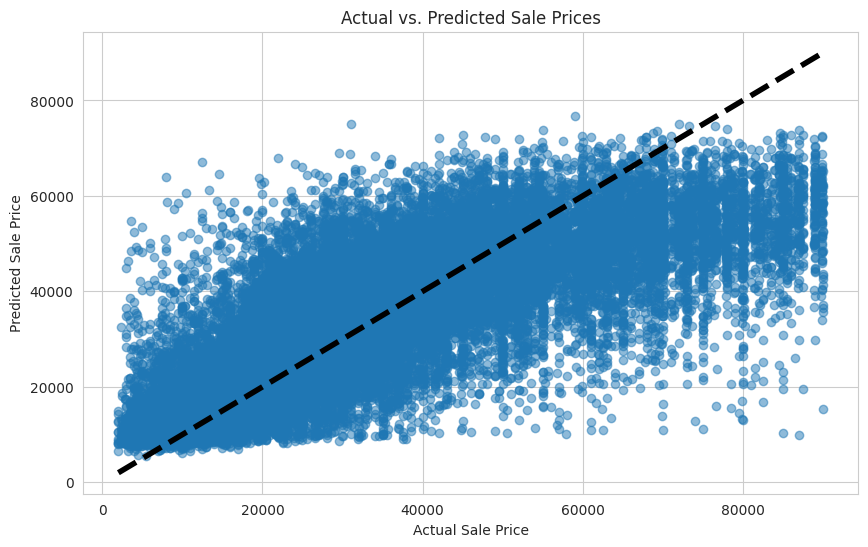

In [26]:
cat_pred = cat_cv.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, cat_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)  # Line representing perfect predictions
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Prices')
plt.show()

In [24]:
# Initialize XGBRegressor with GPU support
XGB = XGBRegressor(
    random_state=13,
    tree_method='gpu_hist',  # Use GPU acceleration
    gpu_id=0,               # Specifies which GPU to use, adjust as per your system
    predictor='gpu_predictor'
)

# Parameter grid for the grid search
param_grid_XGB = {
    'learning_rate': [0.2],
    'n_estimators': [600],
    'max_depth': [5],
    'min_child_weight': [2],
    'gamma': [0.1],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
}

# Setup GridSearchCV
xgb_cv = GridSearchCV(
    XGB,
    param_grid_XGB,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=2
)

# Fit the model
xgb_cv.fit(X_train, y_train)

# Calculate the root mean square error from the best score
rmse = np.sqrt(-1 * xgb_cv.best_score_)
print("Root Mean Squared Error: ", rmse)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:00:50] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:00:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:00:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error:  12228.88827478465


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:02:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:02:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


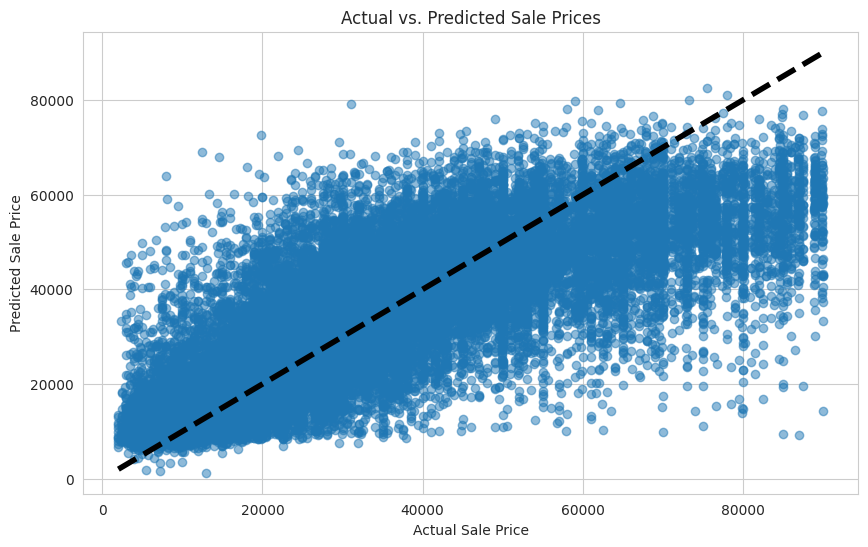

In [25]:
xgb_pred = xgb_cv.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)  # Line representing perfect predictions
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Prices')
plt.show()


In [24]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

lgbm_regressor = lgb.LGBMRegressor()
param_grid_lgbm = {
    'boosting_type':['gbdt'],
    'num_leaves':[50],
    'learning_rate':[.10],
    'n_estimators':[1000]
}

lgbm_cv = GridSearchCV(lgbm_regressor,param_grid_lgbm,cv=3,scoring='neg_mean_squared_error',n_jobs=2)
lgbm_cv.fit(X_train,y_train)
np.sqrt(-1*lgbm_cv.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3405
[LightGBM] [Info] Number of data points in the train set: 139770, number of used features: 11
[LightGBM] [Info] Start training from score 32390.711283


12468.11793816276

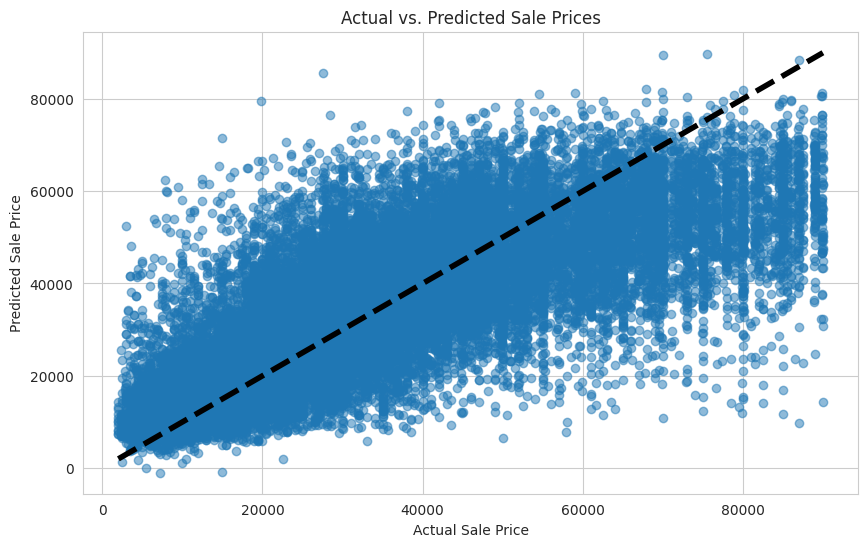

In [25]:
lgbm_pred = lgbm_cv.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, lgbm_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)  # Line representing perfect predictions
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Prices')
plt.show()


In [168]:
from sklearn.model_selection import RandomizedSearchCV

catboost = CatBoostRegressor(loss_function='RMSE', verbose=False)

param_distributions ={
    'iterations': [100, 500, 800],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1]
}

cat_cv = RandomizedSearchCV(catboost, param_distributions, n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

cat_cv.fit(X_train, y_train)

np.sqrt(-1 * cat_cv.best_score_)

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3083, in _catboost._set_features_order_data_pd_data_frame
_catboost.CatBoostError: features data: pandas.DataFrame column 'brand encoded' has dtype 'category' but is not in  cat_features list
